## Import des bibliothèques de code

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

## Import des données

- Le fichier **eco2mix-metropoles-tr_from_2022.csv** correspond aux données de consommation d'énergie électrique dans les grandes métropoles françaises, du 1er janvier 2022 au 1 septembre 2024.

- ***Code métropole*** désigne un identifiant attribué à chaque métropole.

- ***Métropole*** fait référence aux grandes métropoles françaises (ex. : Nantes, Paris, Bordeaux, Marseille, etc.).

- ***Nature*** correspond à la nature des données. Dans notre étude, *Nature* n'a qu'une seule occurrence : "Données temps réel".

- ***Date*** correspond à la date au format aaaa-mm-jj.

- ***Heure*** correspond à l'heure au format hh:mm.

- ***Date - Heure*** correspond à la date et à l'heure au format aaaa-mm-jjThh:mm:ss+02:00, avec +02:00UTC ou +01:00UTC pour l'alignement des heures françaises sur l'horloge universelle UTC (l'heure d'été correspond à +02:00UTC et l'heure d'hiver à +01:00UTC).

- ***Consommation (MW)*** correspond à la consommation de puissance électrique en mégawatts.

- ***Production*** correspond à la production par région. La valeur "ND" indique une absence de données.

- ***Échanges physiques*** correspond au solde des échanges électriques avec les régions voisines.


In [7]:
data_dir = Path('./data')

data = pd.read_csv(data_dir / 'eco2mix-metropoles-tr_from_2022.csv', sep=';')

In [8]:
data.head()

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,244400404,Nantes Métropole,Données temps réel,2022-08-23,15:30,2022-08-23T15:30:00+02:00,342.0,ND,326
1,244400404,Nantes Métropole,Données temps réel,2022-08-23,17:00,2022-08-23T17:00:00+02:00,342.0,ND,327
2,244400404,Nantes Métropole,Données temps réel,2022-08-23,17:15,2022-08-23T17:15:00+02:00,345.0,ND,331
3,244400404,Nantes Métropole,Données temps réel,2022-08-23,17:45,2022-08-23T17:45:00+02:00,339.0,ND,325
4,244400404,Nantes Métropole,Données temps réel,2022-08-23,18:15,2022-08-23T18:15:00+02:00,341.0,ND,329


## Nettoyage, formatage et sélection des données

In [9]:
data.drop(columns=['Code métropole', 'Nature' , 'Date - Heure', 'Production', 'Echanges physiques'], inplace=True)

data['Date'] = ( data['Date'] + ' ' + data['Heures'] )

data.drop(columns='Heures', inplace=True)

# Conversion des colonnes en types spécifiques et indexation des données à partir de la colonne Date
data = (data.astype({
    'Métropole': 'category',
    'Consommation (MW)': 'float',
    })
    .set_index('Date')
)
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.index = data.index.to_period('15min')

In [10]:
data

,Métropole,Consommation (MW)
Date,,
2021-01-01 00:00,Clermont Auvergne Métropole,188.0
2021-01-01 00:00,Métropole Rouen Normandie,552.0
2021-01-01 00:00,Montpellier Méditerranée Métropole,447.0
2021-01-01 00:00,Métropole du Grand Paris,5135.0
2021-01-01 00:00,Métropole Toulon-Provence-Méditerranée,293.0
...,...,...
2024-09-01 23:45,Métropole Rouen Normandie,247.0
2024-09-01 23:45,Nantes Métropole,334.0
2024-09-01 23:45,Métropole Européenne de Lille,746.0


## Détection et gestion des données manquantes

In [11]:
data.isna().sum()

Métropole                0
Consommation (MW)    21829
dtype: int64

Parmi les 2 701 440 données de consommation 21 829 sont manquantes

In [12]:
data.groupby('Métropole').apply(lambda x: x.isna().sum().sum()).to_frame(name='Données manquantes')

,Données manquantes
Métropole,
Bordeaux Métropole,724
Brest Métropole,723
Clermont Auvergne Métropole,994
Dijon Métropole,3695
Eurométropole de Strasbourg,997
Montpellier Méditerranée Métropole,729
Métropole Européenne de Lille,998
Métropole Grenoble-Alpes-Métropole,996
Métropole Nice Côte d'Azur,1004


On utilise la méthode interpolate sur chaque série temporelle associée à chaque Métropole

In [251]:
data_without_Nan = data.groupby('Métropole')['Consommation (MW)'].apply(lambda group: group.interpolate(method='linear'))
data_without_Nan

Métropole                     Date            
Bordeaux Métropole            2021-01-01 00:00    774.0
                              2021-01-01 00:15    792.0
                              2021-01-01 00:30    775.0
                              2021-01-01 00:45    762.0
                              2021-01-01 01:00    757.0
                                                  ...  
Tours Métropole Val de Loire  2024-09-01 22:45    144.0
                              2024-09-01 23:00    159.0
                              2024-09-01 23:15    166.0
                              2024-09-01 23:30    167.0
                              2024-09-01 23:45    169.0
Name: Consommation (MW), Length: 2701440, dtype: float64

On restructure notre DataFrame afin d'avoir les métropoles en colonnes, les dates en index, et en valeurs la puissance en mégawatts pour chaque métropole à un instant T.

In [252]:
data_pivot = data_without_Nan.unstack(level='Métropole')
data_pivot

Métropole,Bordeaux Métropole,Brest Métropole,Clermont Auvergne Métropole,Dijon Métropole,Eurométropole de Strasbourg,Montpellier Méditerranée Métropole,Métropole Européenne de Lille,Métropole Grenoble-Alpes-Métropole,Métropole Nice Côte d'Azur,Métropole Rennes Métropole,...,Métropole Toulon-Provence-Méditerranée,Métropole d'Aix-Marseille-Provence,Métropole de Lyon,Métropole du Grand Nancy,Métropole du Grand Paris,Nantes Métropole,Orléans Métropole,Saint-Etienne Métropole,Toulouse Métropole,Tours Métropole Val de Loire
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00,774.0,136.0,188.0,NaN,425.0,447.0,1013.0,535.0,577.0,303.0,...,293.0,1872.0,1151.0,211.0,5135.0,525.0,268.0,244.0,605.0,292.0
2021-01-01 00:15,792.0,134.0,188.0,NaN,437.0,441.0,1046.0,534.0,568.0,314.0,...,285.0,1900.0,1157.0,205.0,5072.0,532.0,269.0,248.0,602.0,292.0
2021-01-01 00:30,775.0,127.0,185.0,NaN,424.0,426.0,1023.0,524.0,548.0,310.0,...,269.0,1862.0,1126.0,208.0,4982.0,520.0,269.0,245.0,582.0,285.0
2021-01-01 00:45,762.0,125.0,180.0,NaN,418.0,419.0,1003.0,524.0,532.0,302.0,...,268.0,1802.0,1113.0,201.0,4903.0,504.0,262.0,238.0,566.0,283.0
2021-01-01 01:00,757.0,121.0,179.0,NaN,428.0,416.0,1016.0,523.0,527.0,297.0,...,262.0,1703.0,1087.0,200.0,4830.0,500.0,260.0,234.0,557.0,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01 22:45,622.0,92.0,116.0,153.0,333.0,294.0,752.0,302.0,396.0,194.0,...,259.0,1763.0,901.0,168.0,3414.0,344.0,141.0,157.0,464.0,144.0
2024-09-01 23:00,600.0,88.0,117.0,147.0,324.0,280.0,753.0,286.0,392.0,193.0,...,271.0,1773.0,873.0,160.0,3361.0,335.0,137.0,163.0,451.0,159.0
2024-09-01 23:15,584.0,84.0,113.0,144.0,367.0,284.0,745.0,278.0,394.0,188.0,...,303.0,1886.0,863.0,165.0,3373.0,324.0,137.0,149.0,430.0,166.0


In [253]:
data_pivot.isna().sum()

Métropole
Bordeaux Métropole                           0
Brest Métropole                              0
Clermont Auvergne Métropole                  0
Dijon Métropole                           2976
Eurométropole de Strasbourg                  0
Montpellier Méditerranée Métropole           0
Métropole Européenne de Lille                0
Métropole Grenoble-Alpes-Métropole           0
Métropole Nice Côte d'Azur                   0
Métropole Rennes Métropole                   0
Métropole Rouen Normandie                    0
Métropole Toulon-Provence-Méditerranée       0
Métropole d'Aix-Marseille-Provence           0
Métropole de Lyon                            0
Métropole du Grand Nancy                     0
Métropole du Grand Paris                     0
Nantes Métropole                             0
Orléans Métropole                            0
Saint-Etienne Métropole                      0
Toulouse Métropole                           0
Tours Métropole Val de Loire                 0
dty

On remarque qu'il reste des valeurs manquantes pour la métropole de Dijon.
En effet, ces valeurs manquantes correspondent à l'ensemble des données du mois de janvier 2021, sans aucune date en amont (voir ci-dessous).
La méthode d'interpolation ne peut donc pas fonctionner sans ces valeurs en amont.

In [254]:
data_pivot.loc[data_pivot.loc[ :: , 'Dijon Métropole'].isna() , 'Dijon Métropole']

Date
2021-01-01 00:00   NaN
2021-01-01 00:15   NaN
2021-01-01 00:30   NaN
2021-01-01 00:45   NaN
2021-01-01 01:00   NaN
                    ..
2021-01-31 22:45   NaN
2021-01-31 23:00   NaN
2021-01-31 23:15   NaN
2021-01-31 23:30   NaN
2021-01-31 23:45   NaN
Freq: 15T, Name: Dijon Métropole, Length: 2976, dtype: float64

## Affichage

Pour la suite de cette étude, nous travaillerons sur la Métropole du Grand Paris

In [ ]:
# matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

<Axes: title={'center': 'Puissance éléctrique en MegaWatts de la Métropole du Grand Paris'}, xlabel='Date', ylabel='Puissance (MW)'>

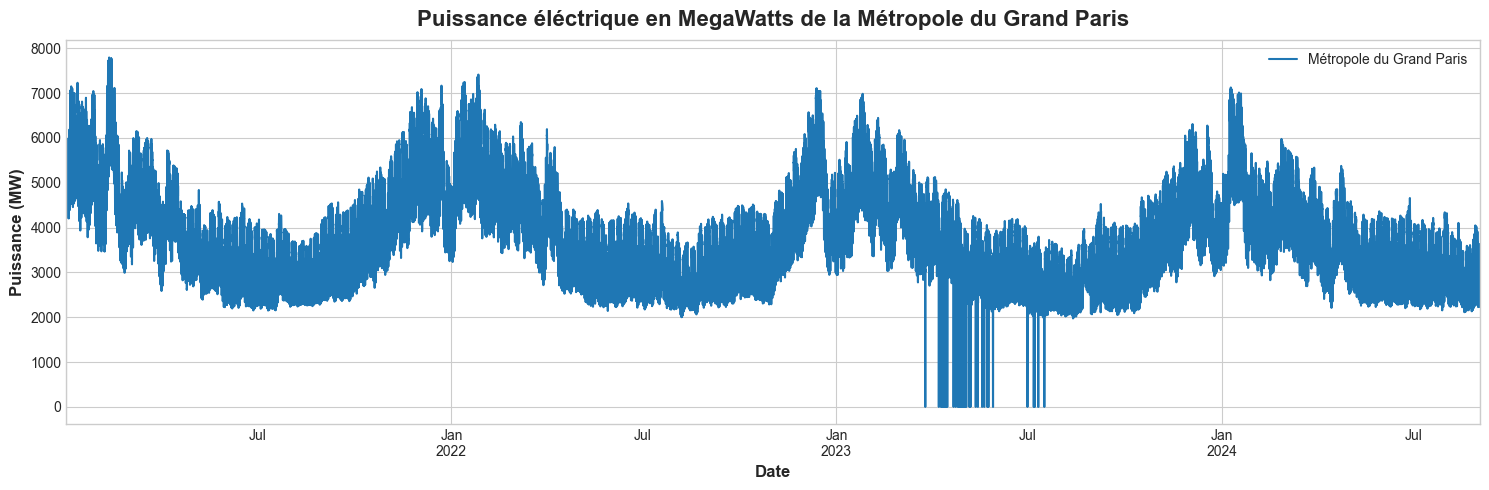

In [255]:
METROPOLE = "Métropole du Grand Paris"
y_time = data_pivot.loc[ :: , METROPOLE].copy()

def plot_serie(y , start = None, end = None, plotParams = None, metropole = METROPOLE):
    if start is None : 
        start = y.index[0]
    if end is None :
        end = y.index[-1]
        
    intervalle = y.loc[start : end]
    if plotParams : 
        ax = intervalle.plot(**plotParams)
    else :
        ax = intervalle.plot()
    ax.set_title(f"Puissance éléctrique en MegaWatts de la {metropole}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Puissance (MW)')
    ax.legend()
    return ax

plot_serie(y_time)

On remarque des valeurs de puissance nulles. Or, l’éclairage public, les systèmes de transport et d’autres équipements électriques fonctionnent en continu.
Ces valeurs nulles peuvent correspondre à d'éventuelles pannes électriques ou à un problème au niveau du système d’acquisition des données.
Dans le cadre de notre étude, nous considérons alors ces données comme des valeurs aberrantes que nous remplacerons par interpolation.

<Axes: title={'center': 'Puissance éléctrique en MegaWatts de la Métropole du Grand Paris'}, xlabel='Date', ylabel='Puissance (MW)'>

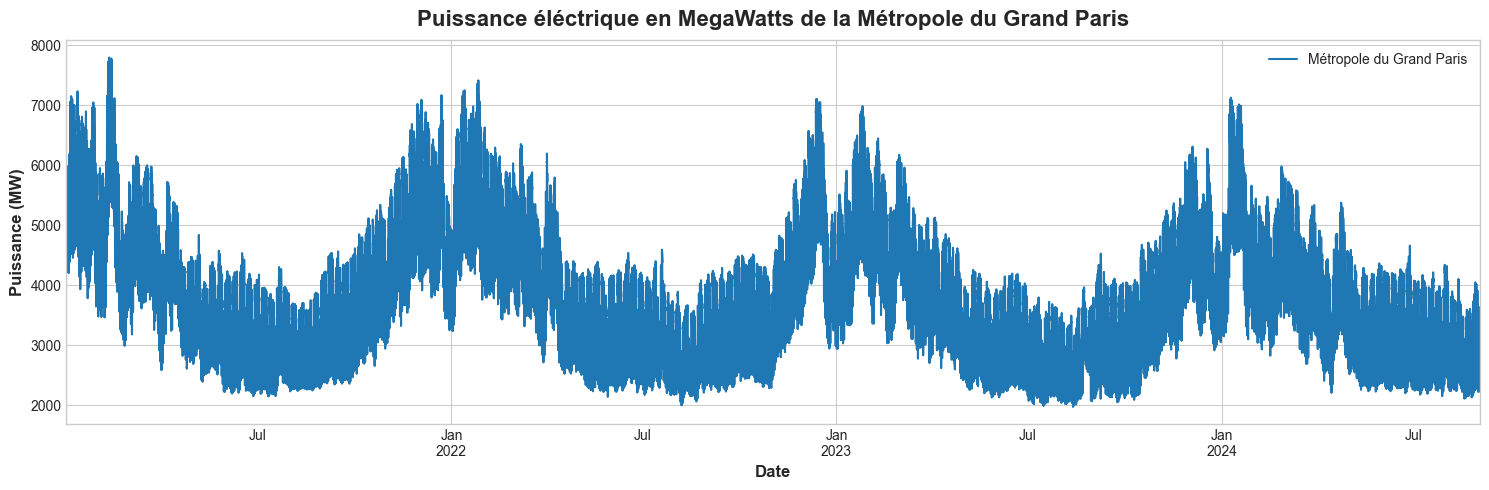

In [256]:
y_time = y_time.squeeze()
y_time[y_time == 0] = pd.NA

y_time.interpolate(method='linear', inplace=True)
y_time = y_time.to_frame()
plot_serie(y_time)

<Axes: title={'center': 'Puissance éléctrique en MegaWatts de la Métropole du Grand Paris'}, xlabel='Date', ylabel='Puissance (MW)'>

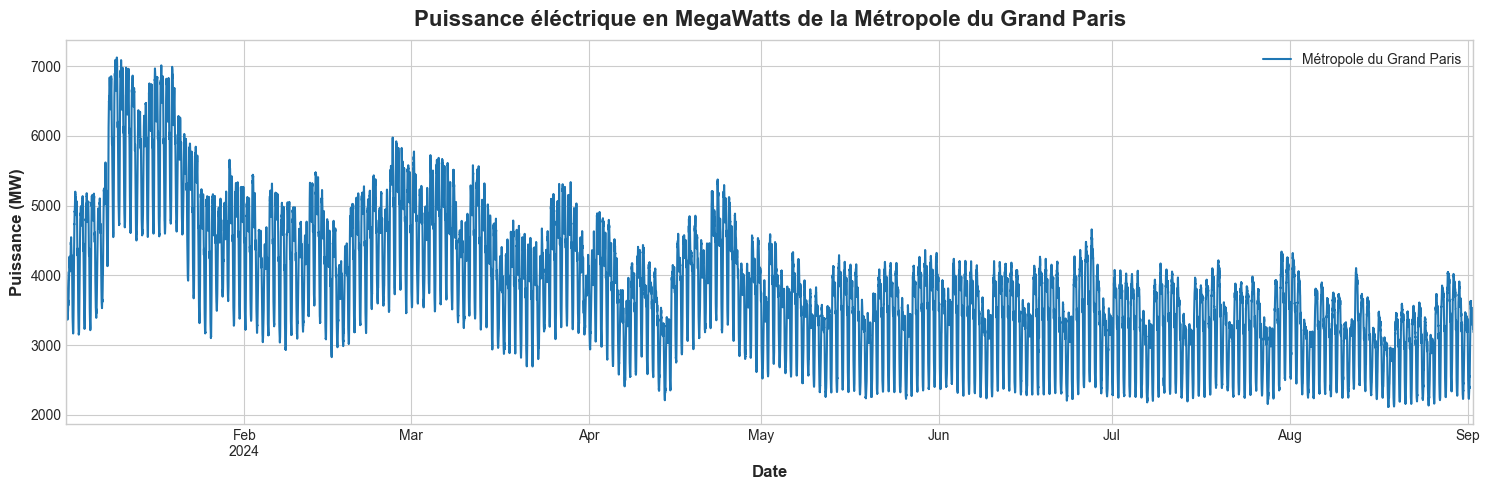

In [257]:
plot_serie(y_time, start='2024-01-01')

## Export des données formatées

In [258]:
data_pivot.to_csv(data_dir / 'Consommation_par_Metropole.csv' , sep=';', header=True , index=True)

In [259]:
y_time.to_csv(data_dir / 'Consommation_Metropole_du_Grand_Paris.csv' , sep=';', header=True , index=True)